<a href="https://colab.research.google.com/github/DidiRamsaran/AI_ML_projects/blob/main/NLPTextClassifier_Project_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2 — text classifier (EMOTIONS)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This code corrisponds to a Natural Language Processing Model (NLP), for analysing tweets with depressive characteristics and random tweets. With this data, we propose to create a model for binary classification into two categories: Depressive and Non-Depressive tweets.

**Team Members:**

* Didi Ramsaran Chin
* Victor Manuel Pietrini Fermín
* Luis Fernando Díaz
* Kevin Fernández

## Dependencias y versión de TensorFlow
---

In [ ]:
# DEPENDENCIAS
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from keras import layers, losses
from google.colab import files



# VERSIÓN TENSORFLOW
print("TensorFlow ver. " + tf.__version__)

TensorFlow ver. 2.15.0


## Otras librerías

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score
from gensim.models import KeyedVectors
import re # regular expresión, se usa en la expansión de contracciones
from math import exp

import numpy as np
from numpy import sign

import nltk # Natural language toolkit,
from nltk.corpus import stopwords # usado en la eliminación de conectores
from nltk import PorterStemmer


from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
!pip3 install ftfy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.6 MB/s eta 0:00:00


In [ ]:
import ftfy as ftfy

## Descarga, Extracción y Preparación de datos
---

Se definen algunos parmetros previo a la carga de datos

In [ ]:
DEPRES_NROWS = 3200  # número de filas a extraer del data set DEPRESSIVE_TWEETS_CSV
RANDOM_NROWS = 4800 # número de filas a extraer del data set RANDOM_TWEETS_CSV.
MAX_SEQUENCE_LENGTH = 140 # max tweet size
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
LEARNING_RATE = 0.1
EPOCHS= 10


In [ ]:
np.random.seed(2505)

# se descarga el conjunto de tweets depresivos
df = '/content/drive/MyDrive/depressive_tweets_processed_transformed.csv'

# data set de tweets random
RANDOM_TWEETS_CSV = '/content/drive/MyDrive/random_tweets_processed_transformed.csv'

depressive_tweets_df = pd.read_csv(df, sep = '|', header = 0, usecols = ["Tweet","Target"], nrows = DEPRES_NROWS)
random_tweets_df = pd.read_csv(RANDOM_TWEETS_CSV, sep = ',', header = 0 ,usecols = ["Tweet","Target"], nrows = RANDOM_NROWS)
#Embedding_file is the file which taken from this link https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download
EMBEDDING_FILE = '/content/drive/MyDrive/GoogleNews-vectors-negative300.bin.gz'

word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)


In [ ]:
print (depressive_tweets_df.head())

                                               Tweet  Target
0  The lack of this understanding is a small but ...       1
1  i just told my parents about my depression and...       1
2  depression is something i don't speak about ev...       1
3  Made myself a tortilla filled with pb&j. My de...       1
4  @WorldofOutlaws I am gonna need depression med...       1


In [ ]:
print (random_tweets_df.head())

                                               Tweet  Target
0                       is so sad for my APL frie...       0
1                     I missed the New Moon trail...       0
2                            omg its already 7:30 :O       0
3            .. Omgaga. Im sooo  im gunna CRy. I'...       0
4           i think mi bf is cheating on me!!!   ...       0


In [ ]:
# en la lista de tweets, existen contracciones propias del inglés que se deben deshacer, por tanto

cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

# se define la función que toma los tweets y expande las contracciones
def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)


# luego se define la función de limpieza de tweets
def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        # se tranforma en str
        tweet = str(tweet)
        # pueden haber links a revistas o artículos, por lo que se eliminan esos url
        # se guarda el tweet con > 10 letras (la palabra depresión en inglés tiene esa cantidad de letras "depression")
        if re.match("(\w+:\/\/\S+)", tweet) == None and len(tweet) > 10:
            # Se remueven #, @menciones, emojis y links de imágenes
            tweet = ' '.join(
                re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)", " ", tweet).split())

            # se arregla el tweet con codificación extraña
            tweet = ftfy.fix_text(tweet)

            # se emplea la función que deshace contracciones
            tweet = expandContractions(tweet)

            # se remueve puntuación, para facilitar el entrenamiento de la RN
            tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())

            # Se guardan los conectores en inglés con la función stopwords (ej. the, a, an, in...)
            # Creo que este objeto puede salir, para no guardar los conectores cada vez que s epricese un tweet
            stop_words = set(stopwords.words('english'))
            # tokenización del tweet
            word_tokens = nltk.word_tokenize(tweet)
            # se remueven los conectores en inglés del tweet
            filtered_sentence = [w for w in word_tokens if not w in stop_words]
            tweet = ' '.join(filtered_sentence)

            # Se procede con ek stemming de las palabras de cada tweet
            tweet = PorterStemmer().stem(tweet)

            # Finalmente, se guarda el tweet en la lista cleanned_tweets
            cleaned_tweets.append(tweet)

    return cleaned_tweets


In [ ]:
display(depressive_tweets_df)

,Tweet,Target
0,The lack of this understanding is a small but ...,1
1,i just told my parents about my depression and...,1
2,depression is something i don't speak about ev...,1
3,Made myself a tortilla filled with pb&j. My de...,1
4,@WorldofOutlaws I am gonna need depression med...,1
...,...,...
3195,Me: I can handle post-grad depression I'm alre...,1
3196,Or maybe because she studied about depression....,1
3197,just had treacle sponge<Emoji: Smiling face wi...,1
3198,"She took depression to Times. No offence, but ...",1


In [ ]:
display(random_tweets_df)

,Tweet,Target
0,is so sad for my APL frie...,0
1,I missed the New Moon trail...,0
2,omg its already 7:30 :O,0
3,.. Omgaga. Im sooo im gunna CRy. I'...,0
4,i think mi bf is cheating on me!!! ...,0
...,...,...
4795,#dontyouhate the people that won't let you go ...,0
4796,#dontyouhate to be in Love with someone that y...,0
4797,#dontyouhate when a woman brags on the coochie...,0
4798,#dontyouhate when drunk ppl r telling u a stor...,0


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Se extraen los tweets de las bases de datos anteriores
depressive_tweets_arr = [x for x in depressive_tweets_df['Tweet']]
random_tweets_arr = [x for x in random_tweets_df['Tweet']]

# Se corre la función de limpieza de tweets en cada lista de tweets
# Depresivos
X_d = clean_tweets(depressive_tweets_arr)
# Random
X_r = clean_tweets(random_tweets_arr)


tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_d + X_r)

sequences_d = tokenizer.texts_to_sequences(X_d)
sequences_r = tokenizer.texts_to_sequences(X_r)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 15200 unique tokens


In [ ]:
data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
data_r = pad_sequences(sequences_r, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data_d tensor:', data_d.shape)
print('Shape of data_r tensor:', data_r.shape)

nb_words = min(MAX_NB_WORDS, len(word_index))

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

for (word, idx) in word_index.items():
    if word in word2vec.index_to_key and idx < MAX_NB_WORDS:
        embedding_matrix[idx-1] = word2vec.word_vec(word)

labels_d = np.array([1] * len(data_d))
labels_r = np.array([0] * len(data_r))

Shape of data_d tensor: (3200, 140)
Shape of data_r tensor: (4736, 140)


In [ ]:
print(embedding_matrix)

[[-0.22558594 -0.01953125  0.09082031 ...  0.02819824 -0.17773438
  -0.00604248]
 [-0.12158203 -0.17089844 -0.41601562 ...  0.2421875   0.2890625
   0.02062988]
 [-0.27929688  0.03417969 -0.05151367 ... -0.00634766 -0.18554688
   0.27148438]
 ...
 [-0.09082031  0.03112793 -0.0005188  ... -0.09716797  0.06689453
   0.29882812]
 [-0.02185059  0.08251953  0.09179688 ... -0.46679688  0.10546875
   0.03100586]
 [ 0.28515625 -0.08203125 -0.0559082  ... -0.29296875  0.34570312
  -0.06103516]]


In [ ]:
depre_x_train, depre_x_test, depre_y_train, depre_y_test = train_test_split(data_d, labels_d, shuffle=False, test_size = 0.2)

In [ ]:
random_x_train, random_x_test, random_y_train, random_y_test = train_test_split(data_r, labels_r, shuffle=False, test_size = 0.2)

In [ ]:
print(depre_x_train)
print(random_y_train)

[[   0    0    0 ...   18  503 6043]
 [   0    0    0 ... 1115  208 3046]
 [   0    0    0 ... 3048   15  154]
 ...
 [   0    0    0 ...  548    1   21]
 [   0    0    0 ...   80   42    7]
 [   0    0    0 ...    3 2922 9810]]
[0 0 0 ... 0 0 0]


In [ ]:
# Se concatenan los tweets depresivos y random del set de training
data_train = np.concatenate((depre_x_train, random_x_train))
print("esto es data_train")
print(data_train)
labels_train = np.concatenate((depre_y_train, random_y_train))
print("esto es labels_train")
print(labels_train)

# Se concatenan los tweets depresivos y random del set de prueba
data_test = np.concatenate((depre_x_test, random_x_test))
print("esto es data_test")
print(data_test)
labels_test = np.concatenate((depre_y_test, random_y_test))
print("esto es labels_test")
print(labels_test)

esto es data_train
[[    0     0     0 ...    18   503  6043]
 [    0     0     0 ...  1115   208  3046]
 [    0     0     0 ...  3048    15   154]
 ...
 [    0     0     0 ...   935 14275    58]
 [    0     0     0 ...    36 14277  1417]
 [    0     0     0 ...   901    43    11]]
esto es labels_train
[1 1 1 ... 0 0 0]
esto es data_test
[[   0    0    0 ... 2511 1349 4228]
 [   0    0    0 ...   89    2  247]
 [   0    0    0 ...   48 9813  351]
 ...
 [   0    0    0 ... 4856 6042 1410]
 [   0    0    0 ... 1108   40   57]
 [   0    0    0 ...  404  726  851]]
esto es labels_test
[1 1 1 ... 0 0 0]


In [ ]:
# Se mezclan los tweets

# de entrenamiento
perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]

# de prueba
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]

In [ ]:
print("Shape of data_train:", data_train.shape)
print("Shape of labels_train:", labels_train.shape)
print("Shape of data_test:", data_test.shape)
print("Shape of labels_test:", labels_test.shape)

Shape of data_train: (6348, 140)
Shape of labels_train: (6348,)
Shape of data_test: (1588, 140)
Shape of labels_test: (1588,)


In [ ]:
print(data_train.shape)
print(labels_train.shape)
print(data_test.shape)
print(labels_test.shape)

(6348, 140)
(6348,)
(1588, 140)
(1588,)


## Crear el modelo
---

In [ ]:
model = tf.keras.Sequential([
    layers.LSTM(64, input_shape=(140, 1), return_sequences=False),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                16896     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Las capas se apilan secuencialmente para construir el clasificar:
1. Capa LSTM (Long Short-Term Memory) es una red neuronal recurrente (RNN) especializada en modelar dependencias temporales en secuencias de datos. En nuestro modelo, se configura con 64 unidades LSTM, lo que quiere decir que esta capa tiene 64 celdas LSTM trabajando juntas para procesar la secuencia de entrada.
2. La salida se canaliza a través de una capa ( `Dense` ) con una sola unidad de salida, (ya que el modelo está diseñado para clasificación binaria). La función de activación utilizada aquí es la sigmoide.

Un modelo necesita una función de pérdida y un optimizador para el entrenamiento. Dado que se trata de un problema de clasificación binaria y el modelo genera una probabilidad (una capa de una sola unidad con una activación sigmoide), utilizará la función de pérdida [`losses.BinaryCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy?hl=es-419).
\
\
Ahora, configuramos el modelo para usar un optimizador y una función de pérdida:

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Entrenar el modelo
---

In [ ]:
data_train_backup = data_train
labels_train_backup = np.array(labels_train).T

print(labels_train_backup)

[0 0 0 ... 0 0 0]


In [ ]:
print(data_train_backup.shape)
print(labels_train_backup.shape)

epochs = 10

history = model.fit(
    x=data_train_backup,
    y=labels_train_backup,
    validation_split=0.2,
    epochs=epochs
)

(6348, 140)
(6348,)
Epoch 1/10
159/159 [==============================] - 16s 81ms/step - loss: 0.5186 - accuracy: 0.7361 - val_loss: 0.4257 - val_accuracy: 0.7992
Epoch 2/10
159/159 [==============================] - 11s 72ms/step - loss: 0.4368 - accuracy: 0.8023 - val_loss: 0.4038 - val_accuracy: 0.8220
Epoch 3/10
159/159 [==============================] - 10s 63ms/step - loss: 0.4128 - accuracy: 0.8115 - val_loss: 0.3758 - val_accuracy: 0.8543
Epoch 4/10
159/159 [==============================] - 12s 74ms/step - loss: 0.3829 - accuracy: 0.8371 - val_loss: 0.3476 - val_accuracy: 0.8748
Epoch 5/10
159/159 [==============================] - 12s 75ms/step - loss: 0.3486 - accuracy: 0.8631 - val_loss: 0.3196 - val_accuracy: 0.8913
Epoch 6/10
159/159 [==============================] - 12s 75ms/step - loss: 0.3141 - accuracy: 0.8824 - val_loss: 0.2992 - val_accuracy: 0.8913
Epoch 7/10
159/159 [==============================] - 10s 64ms/step - loss: 0.2934 - accuracy: 0.8990 - val_loss: 0.

## Evaluar el modelo
---

Veamos cómo se comporta el modelo. se devolverán dos valores. Perdida (un número que representa nuestro error, los valores más bajos mejores) y precisión.

In [ ]:
data_test_backup = data_test
labels_test_backup = labels_test
print(data_test_backup.shape)
print(labels_test_backup.shape)

(1588, 140)
(1588,)


In [ ]:
loss, accuracy = model.evaluate(data_test_backup, labels_test_backup)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

50/50 [==============================] - 1s 20ms/step - loss: 0.2072 - accuracy: 0.9484
Loss:  0.20723611116409302
Accuracy:  0.9483627080917358


## Gráfico de precisión y pérdida a lo largo del tiempo
---

`model.fit()` devuelve un objeto de `History` que contiene un diccionario con todo lo que sucedió durante el entrenamiento:

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Hay cuatro entradas: una para cada métrica monitoreada durante el entrenamiento y la validación. Se pueden utilizar para trazar la pérdida de entrenamiento y validación para comparar, así como la precisión del entrenamiento y la validación:

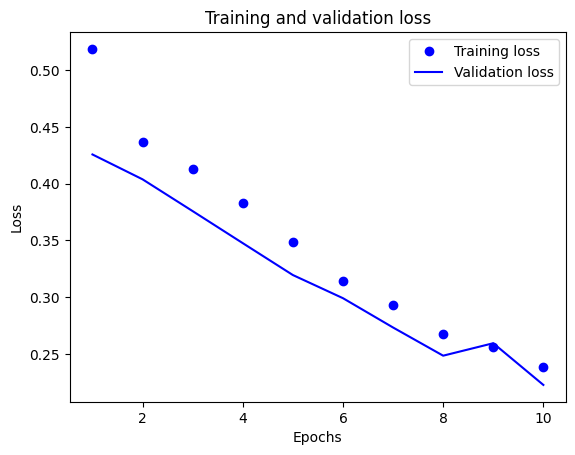

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

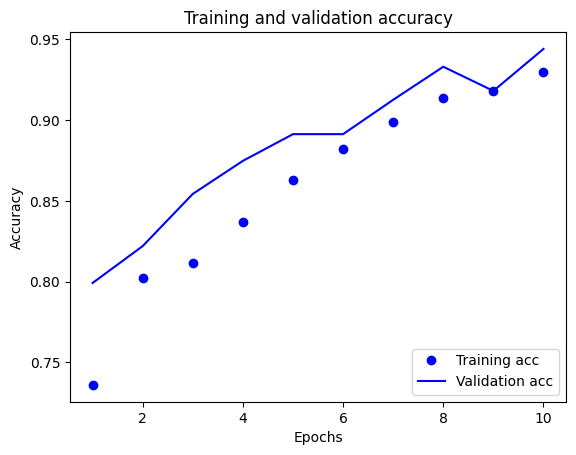

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

En este gráfico, los puntos representan la pérdida y la precisión del entrenamiento, y las líneas sólidas con la pérdida y la precisión de la validación.
\
\
Observe que la pérdida de entrenamiento _disminuye_ con cada época y la precisión del entrenamiento _aumenta_ con cada época. Esto se espera cuando se usa una optimización de descenso de gradiente: debería minimizar la cantidad deseada en cada iteración.
\
\
Este no es el caso de la pérdida de validación y la precisión: parecen alcanzar su punto máximo antes que la precisión del entrenamiento. Este es un ejemplo de sobreajuste: el modelo funciona mejor con los datos de entrenamiento que con los datos que nunca antes había visto. Después de este punto, el modelo sobreoptimiza y aprende representaciones _específicas_ de los datos de entrenamiento que no se _generalizan_ a los daots de prueba.
\
\
Para este caso particular, podría evitar el sobreajuste simplemente deteniendo el entrenamiento cuando la precisón de la validación ya no aumente. Una forma de hacerlo es utilizar la devolución de llamada `tf.keras.callbacks.EarlyStopping`.